# Recommender Systems  Matrix Factorization 
# Introduction
In this task, we will be working on the MovieLens 1M dataset which can be fetched from moivelens . This set contains about 1.000.000 ratings given to about 4.000 movies by about 6.000 users. Our task adopted Matrix Factorization Algorithm in Python and estimated the accuracy with the Root Mean Squared Error, RMSE, and the Mean Absolute Error, MAE.

To make sure that the results are reliable, 5-fold cross-validation is used.



In [1]:
import numpy as np
import pandas as pd
import math
import random
import sys
from sklearn.model_selection import KFold

from math import sqrt

#Import libs to plot the training process
import matplotlib
import matplotlib.pyplot as plt

# Data
The data set we used in this experiment is the MovieLens 1M dataset. There are 5 files in the dataset and we only use the file ratings.csv. The file ratings.csv contains 100836 ratings created by 610 users about 9742 movies; each line of this file below the header represents one rating of one movie(represented by movieId) by one user(represented by userId) and its timestamp. To make things easier, we only use the 3 columns: userId, movieId and rating. The following figure shows how the data looks like: 

![Original Dataset](figures/figure1.png)

<center>figure 1: Some Lines of Ratings.csv</center>

# Approaches
Approaches  to implement recommender system in this assignment are listed below.

## Initial Data Analysis
The purpose of Initial Data Analysis is to understand what is in a dataset and the characteristics of the data.

In [2]:
#Reading The Data into DataFrame
#Define the file path
file_path = './ml-latest-small//ratings.csv'#"./ml-latest-small/ratings.csv" 
df_ratings = pd.read_csv(file_path, header=0, names=['userId', 'movieId', 'rating'], index_col=False)

df_ratings.head(5) #Top 5 records in the dataset 

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [3]:
#The average rating in the dataset
df_ratings.rating.mean()

3.501556983616962

The mean of the ratings is about 3.5

The following figure shows the distribution of the ratings.

/Users/zzfang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


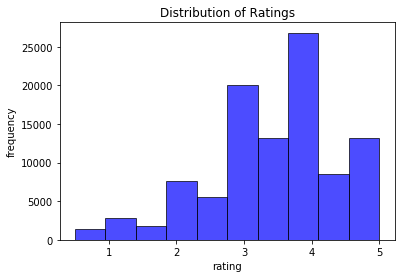

In [4]:
#Show distribution of ratings

data = df_ratings.rating.tolist()

plt.title("Distribution of Ratings")
plt.hist(data, bins=10, normed=0, facecolor="blue", edgecolor='black', alpha=0.7)
plt.xlabel("rating")
plt.ylabel("frequency")

plt.show()

<center>figure 2: Distribution of The Ratings<\center>

In [5]:
#Show huge gap of the numbering 

print("Range of userId: ", "[",df_ratings.userId.min(), ",",df_ratings.userId.max(), "]")
print("Number of userId: ", len(df_ratings.userId.unique()))

print("Range of movieId: ", "[", df_ratings.movieId.min(), ",", df_ratings.movieId.max(), "]")
print("Number of userId: ", len(df_ratings.movieId.unique()))

Range of userId:  [ 1 , 610 ]
Number of userId:  610
Range of movieId:  [ 1 , 193609 ]
Number of userId:  9724


There are are 9724 movies but the movieIds range from 1 to 193609, so there is a huge gap in the numbering of movieIds, which costs huge storage waste and high sparsity in rating matrix.

## Data Preprocessing
The purpose of data preprocessing is to fix the huge gap of the numbering of the original movieId. To reduce the large gap of the numbering, we put the unique movieIds and userIds in lists and use the indices of the lists of new Ids of movies and users. After renumberring the Ids, a rating matrix will be constructed according to the new Ids.

In [6]:
# Renumbering user and movie IDs
uniqueMovieIds = df_ratings.movieId.unique() #Obtain the unique movie Ids
uniqueUserIds = df_ratings.userId.unique() #Obtain the unique user Ids

#Create New movieIds according to unique movie Ids
newMovieIds = [np.where(uniqueMovieIds==x)[0][0] for x in df_ratings['movieId'].tolist()]
newMovieIds = np.array(newMovieIds)

#Create New userIds according to unique user Ids
newUserIds = [np.where(uniqueUserIds==x)[0][0] for x in df_ratings['userId'].tolist()]
newUserIds = np.array(newUserIds)

In [7]:
#Add new movieIds and new userIds to the dataframe
df_ratings['newMovieId'] = newMovieIds
df_ratings['newUserId'] = newUserIds

#Reconstruct the dataframe
df_ratings = df_ratings[["newUserId","newMovieId","rating"]]

In [8]:
#Construct The Rating Matrix acorting to the new ids
num_users = df_ratings['newUserId'].max()+1  #There are 610 users
num_movies = df_ratings['newMovieId'].max()+1 #The Max Value of movieId

ratings = np.zeros((num_users , num_movies))

print(ratings.shape) #Show the shape of the rating matrix

for i in range(df_ratings.shape[0]):
    ratings[df_ratings.loc[i, 'newUserId']][df_ratings.loc[i,'newMovieId']] = df_ratings.loc[i, 'rating']

(610, 9724)


In [9]:
# Calculate the density of the matrix
density = len(np.nonzero(ratings)[0])/(ratings.shape[0]*ratings.shape[1])
print("The density of rating matrix: ", density)

The density of rating matrix:  0.016999683055613623


The density of the rating matrix is about 0.017; it is still very sparse because most users only reviewed few movies compared with the large number of movies.

## Algorithm for Recommandation
We used **Matrix Factorization** for the recommender system. Matrix Factorization is a class of collaborative filtering algorithms. The algorithm attemps to decompose the rating matrix $R$ into the product of 2 lower dimensionality matrices U and M,  in which the users and items are represented in a lower dimensional latent space(K-dimensional Vector).  During the training process, the algorithm will try to minimize the loss function, which is presented by following formula:
<center>$||R_{m,n}- U_{m,k}\times M_{n,k}~T||^2+\lambda (||U_{m, k}||^2 + ||M_{n, k}||^2)$ 
    
In above formula, $||X||^2$ means the sum of squares of items of matrix X:
<center>$||X||^2 = \sum_{x\in X}x^2$
    
**Gradient Descent** is used to minimize the loss function.

After training the parametres of the K-dimensional vectors of users and movies, the rating of movie m given by user u will be the dot product of the user and movie vectors.

<center>$r_{u,m} = u\cdot m$

## Methods for Processing Missing Ids
During the test of a model, there might be some userIds and movieIds which are present in test set but not present in the training set. Because the parametres of the vectors of these users or movies are not trained before, it is unreliable to use the dot product of their vectors to calculate the ratings. Therefore, if user u or movie m is not present in the training set, we will treat the mean of all ratings in the training set as the rating of movie m by user u.

## Cross Validation and Evaluation 
**5-fold** cross validation is applied in our experiment to monitor the training process; i.e. We splitted the data into 5 non-overlapping parts and developed 5 same models; each model will choose one part as test set and the remaining 4 as training set. Mean Squared Error(mse) is used to evaluate the models. The final results will be the average mse of the 5 models.

The code implementing the Matrix Factorization model is listed below

In [11]:
#MatrixFactorization Model
class MatrixFactorization():
    def __init__( self, R=ratings, df=df_ratings, K=20, lr=0.001, rp=0.01, itr= 3, nfolds=5, method='GD', draw=False): 
        #change itr and set thresholds
        """
        Arguments/Hyperparamters
        -R: user-movie: rating matrix
        -K: number of latent dimensions of user & movie vectors
        -lr: learning rate
        -rp: regularization parametre
        -itr: number of iterations
        -df: dataframe of three columns: user, movie and rating
        -method: GD or ALS
        """     
        self.R=R
        self.df = df
        self.num_users, self.num_movies = R.shape
        self.K = K
        self.lr = lr
        self.rp = rp
        self.itr = itr
        self.nfolds = nfolds
        self.method = method
        self.draw=draw
              
    def train_n_times(self):
        # set up the empty result list
        err=[]
        kf = KFold(n_splits= self.nfolds, shuffle=True)
        n_t = 1
        for train_index, test_index in kf.split(self.df):
            print('Training No.', n_t)
            n_t += 1
            training_set, test_set = self.df.iloc[train_index], self.df.iloc[test_index]
            self.check_matrix = np.zeros(self.R.shape)
            training_process = self.train(training_set, test_set)
            err.append(training_process )
        return (err)
            
    def gradient_descent(self, training):
        #Update the parametres of user&movie matrix in one iteration
        for u, m, r in training:
                error = self.R[u][m] - self.predict_um(u,m)
                self.U[u] += self.lr*(error*self.M[m]-self.rp*self.U[u])
                self.M[m] += self.lr*(error*self.U[u] - self.rp*self.M[m])
    
    def ALS(self, training):
        #Update the parametres of user&movie matrix in one iteration
        r_mat= np.zeros((self.num_users , self.num_movies))
        for u, m, r in training:
            r_mat[u][m] = r
        self.U[:,0] = np.mean(r_mat, axis = 1)
        self.M[:,0] = np.mean(r_mat, axis = 0)
        
        for u in range(self.num_users):
            vec = r_mat[u,:].nonzero()[0]
            MI = self.M[vec,:]
            n = max(len(vec),1)
            A = np.dot(MI.T,MI) + self.rp*n*np.eye(self.K)
            V = np.dot(MI.T,r_mat[u,vec])
            self.U[u,:] = np.linalg.solve(A,V)

        for m in range(self.num_movies):
            vec = r_mat[:,m].nonzero()[0]
            UI = self.U[vec,:]
            n = max(len(vec),1)
            A = np.dot(UI.T,UI) + self.rp*n*np.eye(self.K)
            V = np.dot(UI.T,r_mat[vec,m])
            self.M[m,:] = np.linalg.solve(A,V)

    def train(self, training_set, test_set):
        #Initialize user & movie matrices 
        np.random.seed(2019)
        self.U = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        np.random.seed(2019)
        self.M = np.random.normal(scale=1./self.K, size=(self.num_movies, self.K))
        
        #Perform stochastic gradient descent 
        training_process = []
        training = training_set.as_matrix().astype(int)
        test = test_set.as_matrix().astype(int)
        for i in range(self.itr):
            if self.method == 'GD':
                self.gradient_descent(training)
            elif self.method == 'ALS':
                self.ALS(training)
            else:
                sys.exit("Oops! Use GD or ALS as your method")
            mse_training = self.calculate_mse(training)
            mse_test = self.calculate_mse(test, mode="test")
            training_process.append((i, mse_training, mse_test))
        
            print("Iteration: %d; mse_traing: %.4f; mse_test: %.4f"%(i+1, mse_training, mse_test))
        
        if !draw:
            drawplot(training_process)
        return training_process
            
         
    def drawplot(self,training_process):
        iterations = [i for i, mse_training, mse_test in training_process]
        mse_training = [mse_training for i, mse_training, mse_test in training_process]
        mse_test = [mse_test for i, mse_training, mse_test in training_process]
        plt.figure(figsize=(16, 4))
        plt.title("Training Error And Validation Error")
        plt.plot(iterations, mse_training, color='blue', label = 'training error')
        plt.plot(iterations, mse_test, color='orange', label='validation error')
        plt.xticks(iterations, iterations)
        plt.xlabel("Iterations")
        plt.ylabel("Mean Square Error")
        plt.legend()
        plt.grid(axis="y")
        plt.show()
   
    def round_of_rating(self, R):
        R[np.where(R<1)]=1
        R[np.where(R>5)] = 5     
        return R
    
    
    def predictAll(self):
        #Predict All the Ratings, return a full rating matrix
        predictions = self.U.dot(self.M.T)
        return self.round_of_rating(predictions)       
    
    def predict_um(self, u, m, mode="train"):
        #Predict the rating of user u to movie m
        
        if mode=="test":
            if sum(self.check_matrix[u])==0 or sum(self.check_matrix.T[m])==0:
               #userId or movieId not present in training_set                
                   return self.check_matrix.mean()
            return self.U[u,:].dot(self.M[m].T)
            
        
        prediction = self.U[u,:].dot(self.M[m].T)
        self.check_matrix[u][m]=prediction
        return prediction
    
    def calculate_mse(self, d, mode="train"):
        #Calculate mse for Training/Testing set
        #train_pred['diff'] = (d.rating - self.predictALL))**2
        #err_train.append(np.sqrt(train_pred['diff'].mean()))
        num_of_d = len(d)
        error = 0
        
        for i, j, r  in d:
            prediction = self.predict_um(i,j, mode)
            error += (prediction - self.R[i][j] )**2
            
        error = error/num_of_d
        return error

Training No. 1


/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Iteration: 1; mse_traing: 13.3410; mse_test: 13.3670
Iteration: 2; mse_traing: 13.3383; mse_test: 13.3668
Iteration: 3; mse_traing: 13.3349; mse_test: 13.3661
Iteration: 4; mse_traing: 13.3301; mse_test: 13.3640
Iteration: 5; mse_traing: 13.3220; mse_test: 13.3590
Iteration: 6; mse_traing: 13.3066; mse_test: 13.3472
Iteration: 7; mse_traing: 13.2753; mse_test: 13.3205
Iteration: 8; mse_traing: 13.2090; mse_test: 13.2611
Iteration: 9; mse_traing: 13.0674; mse_test: 13.1309
Iteration: 10; mse_traing: 12.7714; mse_test: 12.8552
Iteration: 11; mse_traing: 12.1914; mse_test: 12.3107
Iteration: 12; mse_traing: 11.1941; mse_test: 11.3675
Iteration: 13; mse_traing: 9.8104; mse_test: 10.0473
Iteration: 14; mse_traing: 8.3384; mse_test: 8.6301
Iteration: 15; mse_traing: 7.0794; mse_test: 7.4097
Iteration: 16; mse_traing: 6.0963; mse_test: 6.4525
Iteration: 17; mse_traing: 5.3284; mse_test: 5.7021
Iteration: 18; mse_traing: 4.7164; mse_test: 5.1027
Iteration: 19; mse_traing: 4.2212; mse_test: 4.6

Iteration: 37; mse_traing: 1.5148; mse_test: 1.9808
Iteration: 38; mse_traing: 1.4678; mse_test: 1.9398
Iteration: 39; mse_traing: 1.4242; mse_test: 1.9019
Iteration: 40; mse_traing: 1.3836; mse_test: 1.8669
Training No. 5
Iteration: 1; mse_traing: 13.3419; mse_test: 13.3621
Iteration: 2; mse_traing: 13.3390; mse_test: 13.3619
Iteration: 3; mse_traing: 13.3353; mse_test: 13.3608
Iteration: 4; mse_traing: 13.3294; mse_test: 13.3579
Iteration: 5; mse_traing: 13.3190; mse_test: 13.3507
Iteration: 6; mse_traing: 13.2983; mse_test: 13.3339
Iteration: 7; mse_traing: 13.2548; mse_test: 13.2957
Iteration: 8; mse_traing: 13.1615; mse_test: 13.2105
Iteration: 9; mse_traing: 12.9624; mse_test: 13.0253
Iteration: 10; mse_traing: 12.5544; mse_test: 12.6421
Iteration: 11; mse_traing: 11.7921; mse_test: 11.9219
Iteration: 12; mse_traing: 10.5909; mse_test: 10.7814
Iteration: 13; mse_traing: 9.1152; mse_test: 9.3717
Iteration: 14; mse_traing: 7.7192; mse_test: 8.0277
Iteration: 15; mse_traing: 6.5970;

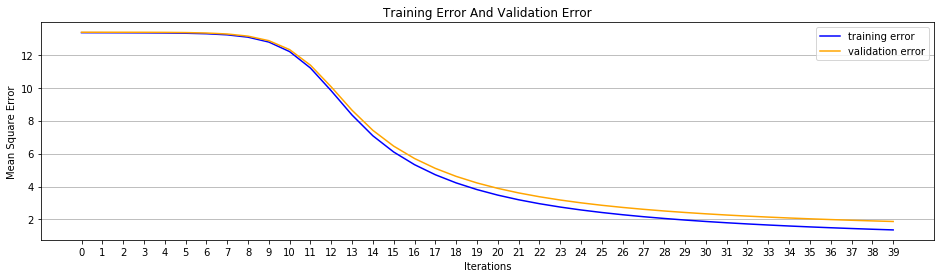

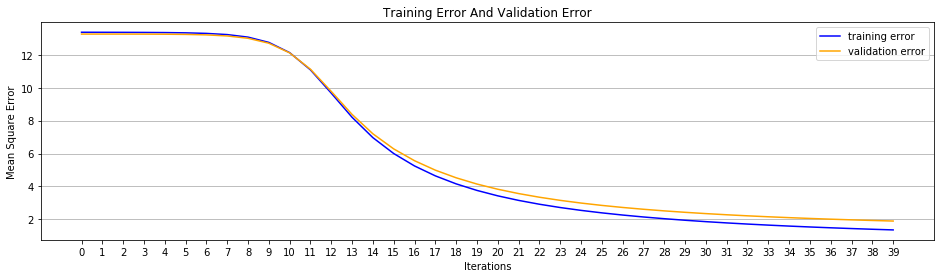

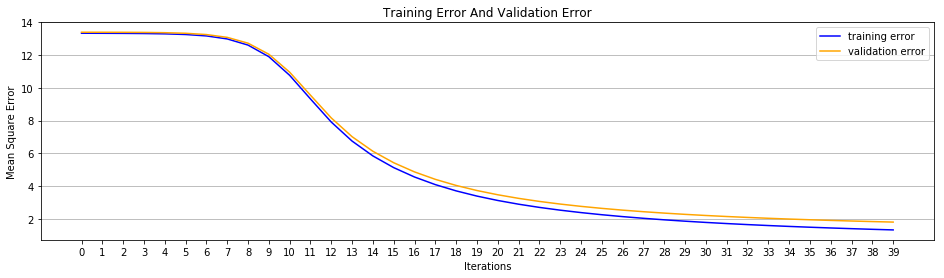

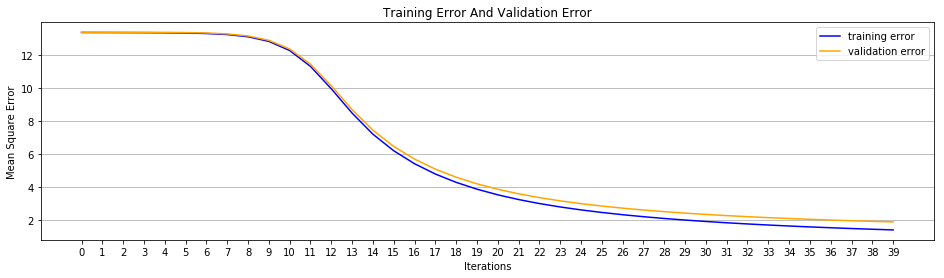

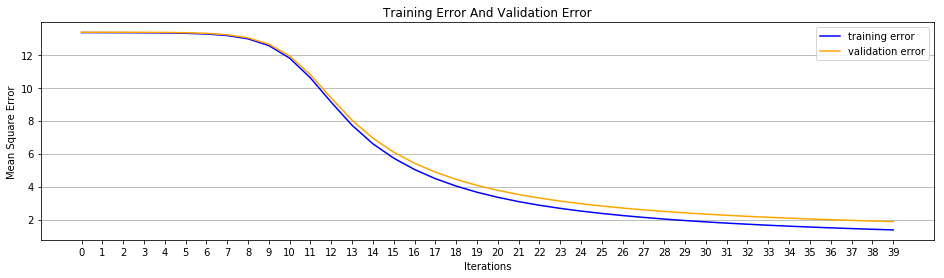

In [33]:
#A running example with 40 iterations
mf = MatrixFactorization(itr=40)
err = mf.train_n_times()

In [34]:
err

[[(0, 13.340983292242175, 13.36700791579983),
  (1, 13.338274219950595, 13.36684522266431),
  (2, 13.334926852520399, 13.366110371066231),
  (3, 13.33009474484998, 13.36403681248753),
  (4, 13.32197920657128, 13.358959522576418),
  (5, 13.306630616169258, 13.347186441095184),
  (6, 13.275330302215938, 13.320533749528622),
  (7, 13.209030060440867, 13.261087718246646),
  (8, 13.067418557519877, 13.13087792629577),
  (9, 12.771435593474497, 12.855214882943265),
  (10, 12.19138545101825, 12.310660798687216),
  (11, 11.194127340161405, 11.3674714545586),
  (12, 9.81037889310444, 10.047261924246284),
  (13, 8.338358763727491, 8.630083502720144),
  (14, 7.079358821592538, 7.409678277174308),
  (15, 6.096346914280169, 6.452500808234211),
  (16, 5.328392709002282, 5.702146163151697),
  (17, 4.716404083837013, 5.102724314837812),
  (18, 4.221157856800997, 4.617032590399031),
  (19, 3.815425620528719, 4.219048021436413),
  (20, 3.479171767545349, 3.889465582315493),
  (21, 3.197347105868971, 3.6

In [35]:
#Print the final test mse
err_final = [e[-1][-1] for e in err]
print("Average Test MSE of The 5 Models: ",np.array(err_final).mean())

Average Test MSE of The 5 Models:  1.8663688714807467


In [238]:
#print the final conclusion:
print("For the MF with GD ")
print("Mean error on TRAIN: " + str(result[1]))
print("Mean error on  TEST: " + str(result[2]))

For the MF with GD 
Mean error on TRAIN: 12.40499678832716
Mean error on  TEST: 12.412558218023136


## Model Optimization
In this section we will discuss the methods to optimize the Matrix Factorization Model, i.e. how to determine the optimal number of iterations, learning rate and latent factors.

### Number of Iterations
Too few iterations can lead to underfitting and too many can lead to overfitting. To find the optimal number of iterations, we need to monitor the value of cross-validation error during the training process. If the cross-validation error decreases with number of iterations increasing, we can improve the performance of the model by increasing iterations. If the cross-validation error starts to increase with the increasing of iterations, we should stop training the model.

In [38]:
mf_1 = MatrixFactorization(itr=100)

In [ ]:
err_1 = mf_1.train_n_times()

Training No. 1


/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Iteration: 1; mse_traing: 13.3345; mse_test: 13.3915
Iteration: 2; mse_traing: 13.3315; mse_test: 13.3910
Iteration: 3; mse_traing: 13.3275; mse_test: 13.3895
Iteration: 4; mse_traing: 13.3212; mse_test: 13.3859
Iteration: 5; mse_traing: 13.3095; mse_test: 13.3773
Iteration: 6; mse_traing: 13.2860; mse_test: 13.3578
Iteration: 7; mse_traing: 13.2366; mse_test: 13.3138
Iteration: 8; mse_traing: 13.1305; mse_test: 13.2164
Iteration: 9; mse_traing: 12.9058; mse_test: 13.0067
Iteration: 10; mse_traing: 12.4515; mse_test: 12.5789
Iteration: 11; mse_traing: 11.6234; mse_test: 11.7939
Iteration: 12; mse_traing: 10.3668; mse_test: 10.5941
Iteration: 13; mse_traing: 8.8874; mse_test: 9.1714
Iteration: 14; mse_traing: 7.5282; mse_test: 7.8577
Iteration: 15; mse_traing: 6.4430; mse_test: 6.8064
Iteration: 16; mse_traing: 5.5987; mse_test: 5.9861
Iteration: 17; mse_traing: 4.9309; mse_test: 5.3347
Iteration: 18; mse_traing: 4.3938; mse_test: 4.8088
Iteration: 19; mse_traing: 3.9561; mse_test: 4.37

# Future Work

## MF with ALS

In [ ]:
r_mat = df_ratings.pivot(index='userId', columns = 'movieId', values = 'rating')

U[:,0] = np.mean(r_mat, axis = 1)
M[:,0] = np.mean(r_mat, axis = 0)

UI = U[:,X[:,j].nonzero()[0]]

for u in range(num_users):
    vec = X[u,:].nonzero()[0]
    MI = M[vec,:]
    n = max(len(vec),1)
    A = np.dot(MI.T,MI) + lmda*n*np.eye(num_features)
    V = np.dot(MI.T,X[u,X[u,:].nonzero()[0]])
    U[u,:] = np.linalg.solve(A,V)
        
for m in range(num_movies):
    vec = X[:,m].nonzero()[0]
    UI = U[vec,:]
    n = max(len(vec),1)
    A = np.dot(UI.T,UI) + lmda*n*np.eye(num_features)
    V = np.dot(UI.T,X[X[:,m].nonzero()[0],j])
    M[m,:] = np.linalg.solve(A,V)
        
pred = np.dot(U.T,M)
    